# The pyabf Cookbook: Membrane Test Theory
_Code examples demonstrating how to calculate holding current (Ih), membrane resistance (Rm), access resistance (Ra), and membrane capacitance (Cm) of a neuron by inspecting the current responses to voltage changes using voltage-clamp mode and whole-cell configuration._

For more resources, see the pyABF project website: http://www.GitHub.com/swharden/pyABF

### Common variables
* $ V_{m} $ - voltage across the cell membrane at a cell at a given time
* $ I_{h} $ - average clamp current at the holding voltage (a.k.a. holding current)
* $ C_{m} $ - membrane capacitance
* $ \Delta V $ - difference in clamp command voltage for a step protocol
* $ \Delta V_{m} $ - the _actual_ change in $ V_{m} $ when the voltage clamp amplifier changes by $ V $*
* $ R_{a}, R_{s} $ - access resistance (synonymous with series resistance)
* $ R_{m} $ - membrane resistance (the true property of the cell membrane)
* $ R_{i} $ - total input resistance ($ R_{a}+R_{m} $)
* $ Q $ - charge (units are A*S, or Coulombs)
* $ I_{c} $ - integrated current over time (units are the same as $ Q $)
* $ I_{0} $ - the peak value of the current transient in response to a voltage step
* $ \tau $ - the time constant of the decay curve of a current transient in response to a voltage step


_* There is a subtle difference between $ \Delta V $ and $ \Delta V_{m} $ due to the fact that the voltage-clamp amplifier is clamping through the resistive $ R_{i} $ but the cell (situated in the middle of the $ R_{a} $ / $ R_{m} $ voltage divider) is only experiencing $ R_{m} $. Therefore, the true cellular voltage will not be exactly the clamp voltage. This is what is overcome by performing series resistance compensation (which we do not use in these examples)._

### Typical Strategy

* Fit the curve to find $ \tau $
* Extrapolate the curve to find $ I_{0} $
* Find charge using $ Q = \tau*I_{0} $
* Calculate $ C_{m} $ using $ C_{m}=Q/\Delta V $

# Sample Data
*And a crash course on extracting signal and command data from ABF files with the pyabf package*

This sample data was generated by recording a model cell (hardware). Its values according to Clampex are:

* Cm: 30.7 pF
* Rm: 517 MOhm
* Ra: 8 MOhm
* Tau: 0.25 ms
* Hold: -138.9 pA

First, prepare the environment and import the pyabf package:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3)

import sys
sys.path.insert(0, '../src/')
import pyabf

Now let's load some files we will use throughout this document:

In [2]:
abfStep = pyabf.ABF(R"../data/model_vc_step.abf")
abfRamp = pyabf.ABF(R"../data/model_vc_ramp.abf")

## Inspecting the ABF files
We will now inspect each of these files by graphing their signal (current) vs command (voltage)

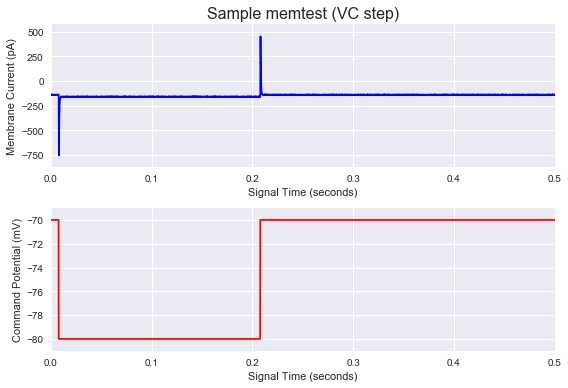

In [3]:
plt.subplot(211)
plt.plot(abfStep.dataX,abfStep.dataY,'b')
abfStep.plotDecorate(title="Sample memtest (VC step)")
plt.subplot(212)
plt.plot(abfStep.dataX,abfStep.dataC,'r')
abfStep.plotDecorate(command=True,title=False)

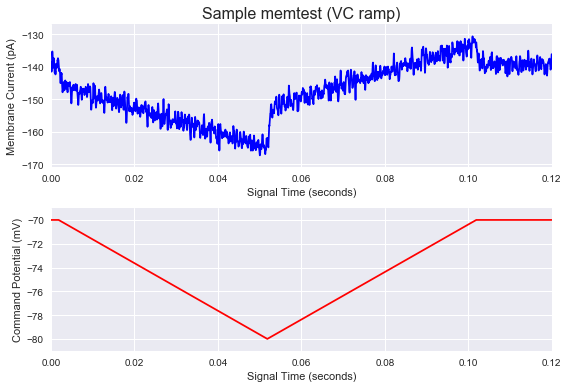

In [4]:
plt.subplot(211)
plt.plot(abfRamp.dataX,abfRamp.dataY,'b')
abfRamp.plotDecorate(title="Sample memtest (VC ramp)")
plt.subplot(212)
plt.plot(abfRamp.dataX,abfRamp.dataC,'r')
abfRamp.plotDecorate(command=True,title=False)

## Breaking data apart
We can use `abf.epochData(epochNumber)` to extract times/data/command from a single epoch:

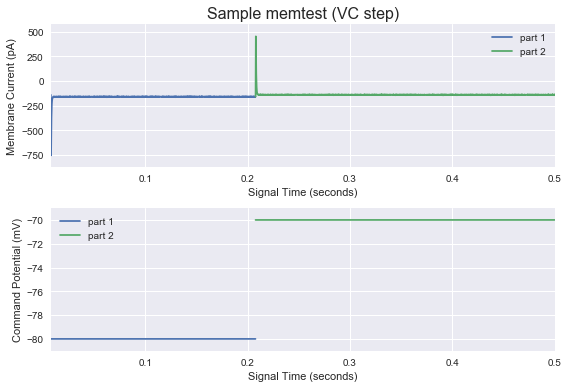

In [5]:
Xs1,Ys1,Cs1=abfStep.epochData(epochNumber=0)
Xs2,Ys2,Cs2=abfStep.epochData(epochNumber=1)

plt.subplot(211)
plt.plot(Xs1,Ys1,label="part 1")
plt.plot(Xs2,Ys2,label="part 2")
abfStep.plotDecorate(legend=True,title="Sample memtest (VC step)")

plt.subplot(212)
plt.plot(Xs1,Cs1,label="part 1")
plt.plot(Xs2,Cs2,label="part 2")
abfStep.plotDecorate(legend=True,command=True,title=None)

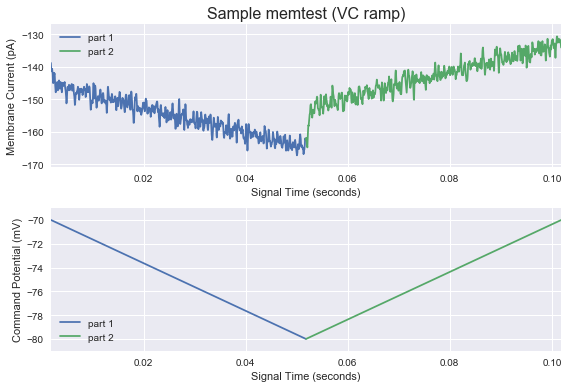

In [6]:
Xs1,Ys1,Cs1=abfRamp.epochData(epochNumber=0)
Xs2,Ys2,Cs2=abfRamp.epochData(epochNumber=1)

plt.subplot(211)
plt.plot(Xs1,Ys1,label="part 1")
plt.plot(Xs2,Ys2,label="part 2")
abfRamp.plotDecorate(legend=True,title="Sample memtest (VC ramp)")

plt.subplot(212)
plt.plot(Xs1,Cs1,label="part 1")
plt.plot(Xs2,Cs2,label="part 2")
abfRamp.plotDecorate(legend=True,command=True,title=None)

# Calculating Membrane Resistance ($ R_{m} $)
First we calculate $ {\Delta I} $, then using Ohm's law realize $ R_{m} = \Delta V / \Delta I $. This can be calculated using advanced features (shown below), but this quick and dirty calculation will get us started.

In [7]:
abfStep = pyabf.ABF(R"../data/model_vc_step.abf")
Xs1,Ys1,Cs1=abfStep.epochData(epochNumber=0)
Xs2,Ys2,Cs2=abfStep.epochData(epochNumber=1)
Im1=np.average(Ys1[-int(len(Ys1)/2):])
Im2=np.average(Ys2[-int(len(Ys1)/2):])
Vm1=Cs1[1]
Vm2=Cs2[1]
dVm=np.abs(Vm1-Vm2)
dIm=np.abs(Im1-Im2)
Rm=((dVm*1e-3)/(dIm*1e-12))*1e-6
print("clamp voltages (mV):", Vm1, Vm2)
print("delta V (mV):", dVm)
print("steady state currents (pA):", Im1, Im2)
print("delta I (pA):", dIm)
print("Rm (MOhm):",Rm)

clamp voltages (mV): -80.0 -70.0
delta V (mV): 10.0
steady state currents (pA): -158.812 -139.201
delta I (pA): 19.611
Rm (MOhm): 509.917306501


# Calculating Membrane Capacitance ($ C_{m} $)
There are several methods to calculate $ C_{m} $, each with their advantages and disadvantages. When reviewing the topic, I found these resources useful: [Membrane Capacitance Measurements Revisited](http://jn.physiology.org/content/102/4/2161) and [Accurate cell capacitance determination from a single voltage step](http://ajpheart.physiology.org/content/ajpheart/311/4/H1072.full.pdf)


## Method 1: Curve-Fitting
***A pretty good estimation of $ C_{m} $ can be found by integrating the transient of a voltage-clamp step***

The idea here is that the integrated transient ($ I_{d} $) is a pretty good approximation of $ C_{m} $ and can be performed with minimal complexity.

We start by focusing in on a single transient. Let's take the first one for simplicity.

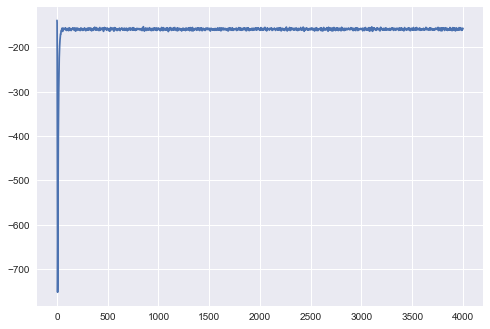

In [8]:
abfStep = pyabf.ABF(R"../data/model_vc_step.abf")
Xs,Ys,Cs=abfStep.epochData(epochNumber=0)
plt.plot(Ys);

We need to center this data on the steady state current. In quiet data like this, the easiest way is just to get the average of the last half of the segment.

Although an average (perhaps the average of the last 50% of the data) is good in quiet data, the pyabf package has a "tonic" function hidden away that determines steady state values as the peak of the curve-fitted histogram of the data:

```python
# alternative method of determining steady state
steadyState=abfStep._tonic(lastHalf)
```

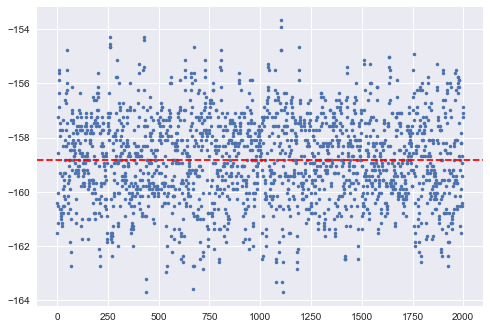

In [9]:
lastHalf=Ys[-int(len(Ys)/2):] # get only the last half of the epoch segment
plt.plot(lastHalf,'.')
steadyState=np.average(lastHalf)
plt.axhline(steadyState,ls='--',color='r');

Now subtract-out the steady state from the original data to center it at 0. Then invert it so we always work with positive units.

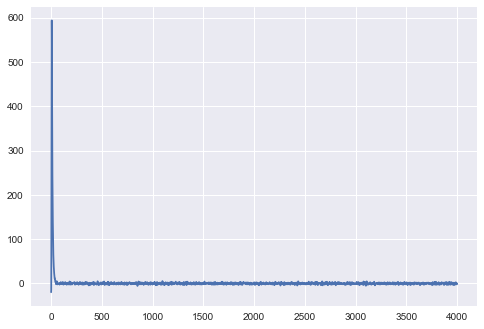

In [10]:
Ys-=steadyState
Ys*=-1
plt.plot(Ys);

Let's delete uninteresting data (the first few points below 0, and all the points after the trace returns to 0)

In [11]:
print(Ys)
cutOffFirstPoints=np.where(Ys>0)[0][0]
Ys=Ys[cutOffFirstPoints:] # cut-off the fist few data points below 0
Ys=Ys[:np.where(Ys<=0)[0][0]] # only keep data until zero is crossed again
print(Ys)

[-19.652 -14.892  59.571 ...,  -1.586  -1.952  -1.708]
[  59.571  235.231  429.078  556.153  593.507  564.21   502.442  433.717
  372.193  321.778  279.786  243.287  211.549  184.205  160.279  139.039
  120.729  104.615   89.967   76.539   65.065   56.52    49.562   43.58
   38.575   33.448   28.932   26.002   23.316   20.265   16.969   14.283
   11.964   11.354   11.598   10.621    9.156    8.302    6.227    5.006
    4.396    3.541    3.907    2.687    1.1  ]


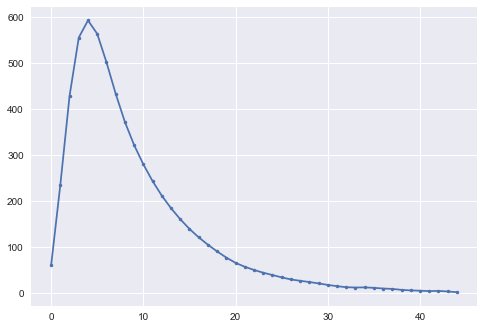

In [12]:
plt.plot(Ys,'.-');

We only want to curve-fit the interesting area. Note that fitting higher values (i.e., 80% or 90%) is intentionally avoided because they have a high $dI/dt $ which means they are disproportionately distorted by the hardware low-pass filtering. I prefer fitting 50% to 5%.

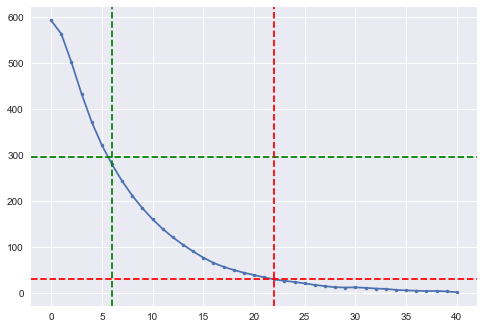

In [13]:
YsOriginal = np.array(Ys) # we will use this later
cutOffPoints=0 # every time we cut off some of the Ys, we will keep track

peakVal=np.max(Ys)
peakI=np.where(Ys==peakVal)[0][0]
Ys=Ys[peakI:]
cutOffPoints+=peakI
plt.plot(Ys,'.-');

upperVal=peakVal*.5
lowerVal=peakVal*.05

plt.axhline(upperVal,color='g',ls='--')
plt.axhline(lowerVal,color='r',ls='--')

upperI=np.where(Ys<upperVal)[0][0]
lowerI=np.where(Ys<lowerVal)[0][0]

plt.axvline(upperI,color='g',ls='--')
plt.axvline(lowerI,color='r',ls='--');

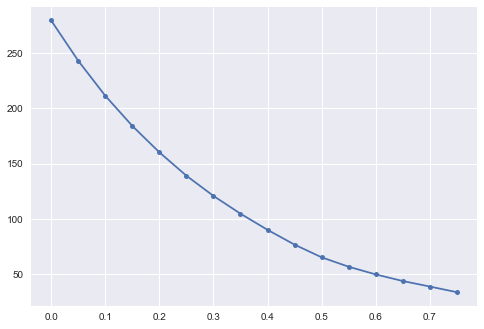

In [14]:
fitThis=Ys[upperI:lowerI]
cutOffPoints+=upperI

Xs=np.arange(len(fitThis))*abfStep.pointDurMS
plt.plot(Xs,fitThis,'.-',ms=10);

Fit this curve with SciPy (and calculate $ tau $)

In [15]:
import scipy.optimize

def algoMonoExp(x, m, t, b):
    return m*np.exp(-t*x)+b

params, cv = scipy.optimize.curve_fit(algoMonoExp, Xs, fitThis, p0=(1,1e-6,1))
m,t,b=params
tau=1/t # units are the same units as Xs

print("tau: %.03f ms"%(tau))

tau: 0.360 ms


Note: When I measure with CJFLab (using 50% and 5%), I get a Cm of 0.357 ms. Note that ClampEx reported 0.250 ms.

Now let's inspect our fit

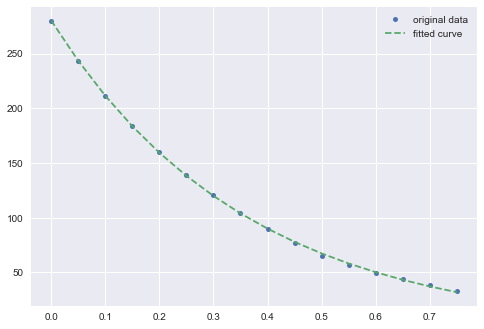

In [16]:
plt.plot(Xs,fitThis,'.',label="original data",ms=10)
plt.plot(Xs,algoMonoExp(Xs,m,t,b),'--',label="fitted curve")
plt.legend();

Let's use our params to extrapolate backwards by `cutOffFirstPoints`

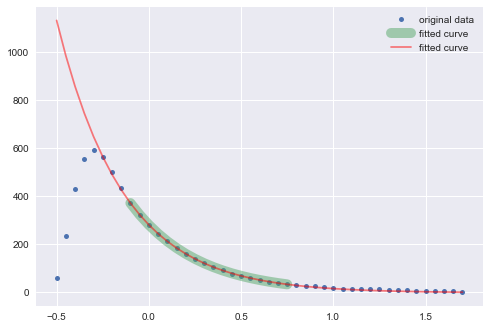

In [17]:
Xs0=np.arange(len(YsOriginal))*abfStep.pointDurMS
Xs0-=(cutOffPoints)*abfStep.pointDurMS
plt.plot(Xs0,YsOriginal,'.',label="original data",ms=10)

Xs2=(np.arange(len(fitThis)+cutOffFirstPoints)-cutOffFirstPoints)*abfStep.pointDurMS
plt.plot(Xs2,algoMonoExp(Xs2,m,t,b),lw=10,alpha=.5,label="fitted curve")

plt.plot(Xs0,algoMonoExp(Xs0,m,t,b),alpha=.5,color='r',label="fitted curve")

plt.legend();

What is our first value? $ I_{0} $? This can be used to calculate interesting things. Note that $ Q = I_{0} * tau $

In [45]:
I0=extrapolatedTransient[0]
print("I0: %.03f pA"%I0)
Q=(I0*1e-12)*(tau*1e-3)
print("Q (pC):",Q*1e12)
Cm = Q/(dVm*1e-3) # 10 mV step
print("Cm (pF):",Cm*1e12)

I0: 1133.800 pA
Q (pC): 0.408396456162
Cm (pF): 40.8396456162


This is a close estimation, but we can do better.

Note: When I measure with CJFLab (using 50% and 5%), I get a Cm of 22.64456 pF. Note that ClampEx reported 30.7 pF.

Note: there is a slight difference between dV and dVm. It is shown here. It's so small, I'll ignore it from now, but in the future dVm2 should be used for critical calculations.

In [31]:
dVm2=dVm*(1-dIm/I0)
print("command dV (mV):",dVm)
print("membrane dV (mV):",dVm2)

command dV (mV): 10.0
membrane dV (mV): 9.82703282167


In [43]:
Ra = Rm*(dVm/dVm2-1) # MOhm units
print("Ra: %.03f MOhm"%Ra)

Ra: 8.975 MOhm


This is close to clamp-fit's prediction (8 MOhm) but far from CJFLab (16.3 MOhm)